In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import random

# Device setup
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using:", DEVICE)

# Class mapping
CHAR_CLASSES = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'plus', 'minus', 'mul', 'div', 'eq']
CHAR_TO_IDX = {c: i for i, c in enumerate(CHAR_CLASSES)}
IDX_TO_CHAR = {i: c for c, i in CHAR_TO_IDX.items()}


Using: mps


In [2]:
import os
import re
from torch.utils.data import Dataset
from PIL import Image
import torch

class EquationDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)

        # Extract base name before _ (e.g. "2plus3eq5" from "2plus3eq5_53.png")
        name = os.path.basename(img_path).split("_")[0]

        # Parse into tokens: digits and operators
        tokens = re.findall(r'(plus|minus|mul|div|eq|\d)', name)

        # Ensure exactly 5 tokens (A op B = C)
        if len(tokens) != 5:
            raise ValueError(f"Invalid label in file: {img_path}")

        # Convert tokens to indices
        label = [CHAR_TO_IDX[t] for t in tokens]
        return img, torch.tensor(label)


In [3]:
class EquationCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.classifier1 = nn.Linear(64 * 7 * 7, num_classes)
        self.classifier2 = nn.Linear(64 * 7 * 7, num_classes)
        self.classifier3 = nn.Linear(64 * 7 * 7, num_classes)
        self.classifier4 = nn.Linear(64 * 7 * 7, num_classes)
        self.classifier5 = nn.Linear(64 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.features(x)
        return [self.classifier1(x), self.classifier2(x),
                self.classifier3(x), self.classifier4(x),
                self.classifier5(x)]


In [4]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

# Load dataset
dataset = EquationDataset("../data/equations", transform=transform)

# Split into train and test sets (80/20)
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)


In [5]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

In [6]:
img, label = dataset[0]
print(label)


tensor([ 4, 12,  1, 14,  4])


In [7]:
len(dataset)

2031

In [8]:
model = EquationCNN(num_classes=len(CHAR_CLASSES)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(70):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)

        loss = sum(criterion(output, labels[:, i]) for i, output in enumerate(outputs))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")


Epoch 1 - Loss: 8.0083
Epoch 2 - Loss: 5.4950
Epoch 3 - Loss: 2.6795
Epoch 4 - Loss: 1.6700
Epoch 5 - Loss: 1.2240
Epoch 6 - Loss: 0.9010
Epoch 7 - Loss: 0.7131
Epoch 8 - Loss: 0.5785
Epoch 9 - Loss: 0.4448
Epoch 10 - Loss: 0.4260
Epoch 11 - Loss: 0.3355
Epoch 12 - Loss: 0.2632
Epoch 13 - Loss: 0.2262
Epoch 14 - Loss: 0.1883
Epoch 15 - Loss: 0.1336
Epoch 16 - Loss: 0.1245
Epoch 17 - Loss: 0.1042
Epoch 18 - Loss: 0.0851
Epoch 19 - Loss: 0.0735
Epoch 20 - Loss: 0.0570
Epoch 21 - Loss: 0.0486
Epoch 22 - Loss: 0.0422
Epoch 23 - Loss: 0.0337
Epoch 24 - Loss: 0.0275
Epoch 25 - Loss: 0.0210
Epoch 26 - Loss: 0.0162
Epoch 27 - Loss: 0.0150
Epoch 28 - Loss: 0.0125
Epoch 29 - Loss: 0.0114
Epoch 30 - Loss: 0.0104
Epoch 31 - Loss: 0.0099
Epoch 32 - Loss: 0.0092
Epoch 33 - Loss: 0.0082
Epoch 34 - Loss: 0.0075
Epoch 35 - Loss: 0.0064
Epoch 36 - Loss: 0.0059
Epoch 37 - Loss: 0.0056
Epoch 38 - Loss: 0.0049
Epoch 39 - Loss: 0.0045
Epoch 40 - Loss: 0.0043
Epoch 41 - Loss: 0.0039
Epoch 42 - Loss: 0.0037
E

In [9]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for img, label in test_loader:
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        outputs = model(img)
        preds = torch.stack([torch.argmax(o, dim=1) for o in outputs], dim=1)
        correct += (preds == label).all(dim=1).sum().item()
        total += label.size(0)

print(f"✅ Test accuracy: {correct}/{total} ({100 * correct / total:.2f}%)")
# View incorrect predictions from test set
for img, label in test_loader:
    img = img.to(DEVICE)
    label = label.to(DEVICE)
    with torch.no_grad():
        outputs = model(img)
        pred = torch.stack([torch.argmax(o, dim=1) for o in outputs], dim=1)
        if not torch.equal(pred, label):
            true_str = ''.join(IDX_TO_CHAR[i.item()] for i in label[0])
            pred_str = ''.join(IDX_TO_CHAR[i.item()] for i in pred[0])
            print(f"❌ Predicted: {pred_str}  |  True: {true_str}")


✅ Test accuracy: 357/407 (87.71%)
❌ Predicted: 4plus3eq6  |  True: 4plus2eq6
❌ Predicted: 3plus4eq9  |  True: 3plus4eq7
❌ Predicted: 3minus1eq2  |  True: 5minus3eq2
❌ Predicted: 1mul1eq6  |  True: 1mul6eq6
❌ Predicted: 5minus3eq0  |  True: 3minus3eq0
❌ Predicted: 2minus1eq1  |  True: 9minus1eq8
❌ Predicted: 5plus4eq7  |  True: 3plus4eq7
❌ Predicted: 1minus4eq1  |  True: 1minus0eq1
❌ Predicted: 9minus9eq0  |  True: 7minus7eq0
❌ Predicted: 8minus0eq2  |  True: 2minus0eq2
❌ Predicted: 0mul1eq0  |  True: 0mul8eq0
❌ Predicted: 0plus0eq6  |  True: 6plus0eq6
❌ Predicted: 2plus1eq8  |  True: 2plus1eq3
❌ Predicted: 0plus1eq8  |  True: 0plus8eq8
❌ Predicted: 9minus0eq2  |  True: 2minus0eq2
❌ Predicted: 2plus6eq9  |  True: 3plus6eq9
❌ Predicted: 4minus3eq7  |  True: 6minus3eq3
❌ Predicted: 5plus6eq9  |  True: 5plus4eq9
❌ Predicted: 6mul0eq6  |  True: 6mul0eq0
❌ Predicted: 9minus1eq6  |  True: 7minus1eq6
❌ Predicted: 9mul1eq5  |  True: 5mul1eq5
❌ Predicted: 0plus0eq9  |  True: 0plus9eq9
❌ Predicte

In [10]:
torch.save(model.state_dict(), "equation_model.pt")
print("✅ Model saved")


✅ Model saved


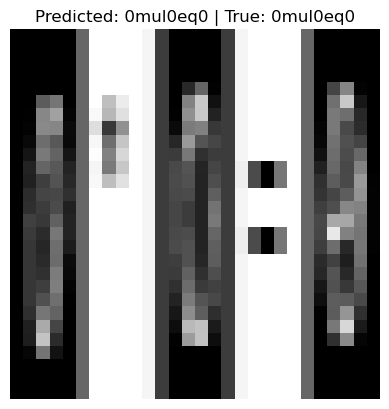

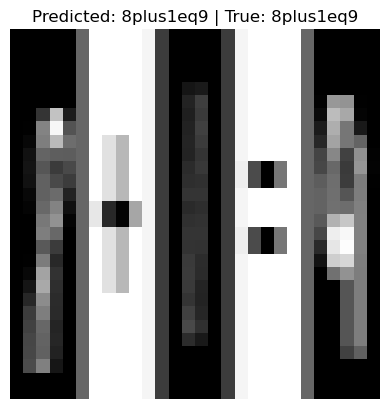

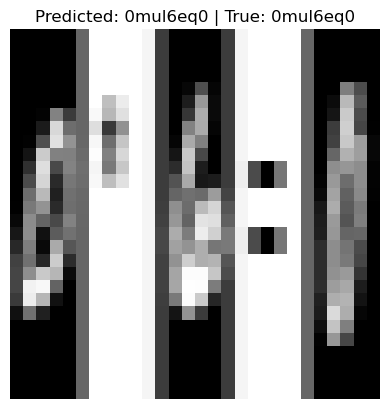

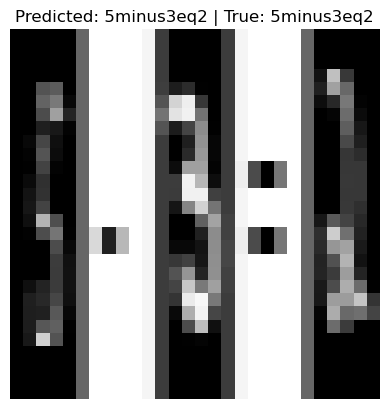

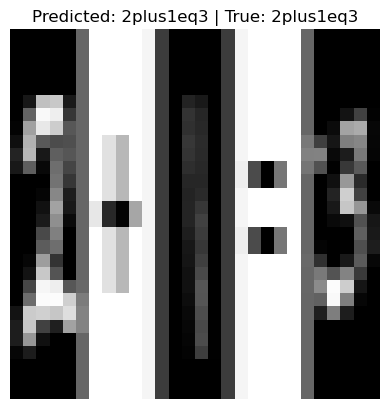

In [11]:
import matplotlib.pyplot as plt

def predict(img_tensor):
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.unsqueeze(0).to(DEVICE)
        outputs = model(img_tensor)
        preds = [torch.argmax(out, dim=1).item() for out in outputs]
        return ''.join([IDX_TO_CHAR[p] for p in preds])

# Show 5 random predictions
for i in range(5):
    idx = random.randint(0, len(dataset) - 1)
    img, label = dataset[idx]
    pred = predict(img)
    label_str = ''.join([IDX_TO_CHAR[x.item()] for x in label])

    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Predicted: {pred} | True: {label_str}")
    plt.axis("off")
    plt.show()
